In [103]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [104]:
data_dir = '../data/images/train/'

transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.CenterCrop(224),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_set = ImageFolder(data_dir, transform=transform, target_transform=None)
data_loader = DataLoader(data_set, batch_size=1, shuffle=True)

In [105]:
model = torch.load('../models/ResNet18_pretrained-epoch278-batch_size32-lr0.001-loss0.1709.pt')
model.eval()
device = next(model.parameters()).device.type

closed


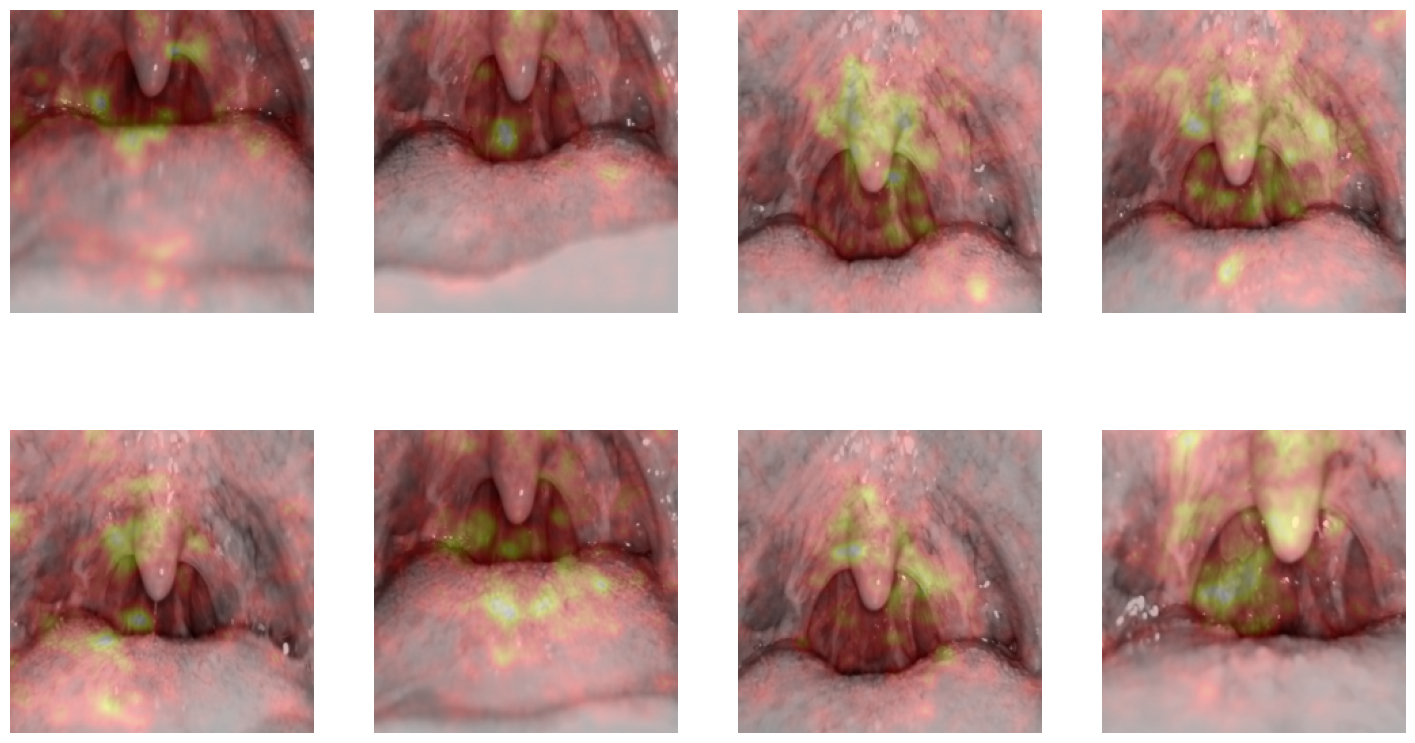

In [106]:
def plot_saliency_maps(model, data_loader, label, num_plots=8):
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    for idx in range(num_plots):

        images, labels = next(iter(data_loader))
        output_idx = -1
        while labels.numpy()[0] != label or output_idx != label: # find an image with the correct stated and predicted label
            images, labels = next(iter(data_loader))

            input_batch = images
            input_batch = input_batch.to(device)
            input_batch.requires_grad_()

            output = model(input_batch)
            output_idx = output.argmax()

        output[0, output_idx].backward()

        saliency_map = np.resize(input_batch.grad.data.abs().squeeze()[0].cpu().numpy(), (input_batch.shape[2], input_batch.shape[3]))
        saliency_map = gaussian_filter(saliency_map, sigma=4) # smooth out the saliency map

        image = input_batch.squeeze().permute(1, 2, 0).cpu().detach().numpy()
        grey_img = np.dot(image[..., :3], [0.299, 0.587, 0.114])

        axes[idx // num_cols, idx % num_cols].imshow(grey_img, cmap='gray')
        axes[idx // num_cols, idx % num_cols].imshow(saliency_map, cmap='hot', alpha=0.3)
        axes[idx // num_cols, idx % num_cols].axis('off')
        # axes[idx // num_cols, idx % num_cols].set_title(labels.numpy()[0])
    plt.show()

print('closed')
plot_saliency_maps(model, data_loader, 0)

equal


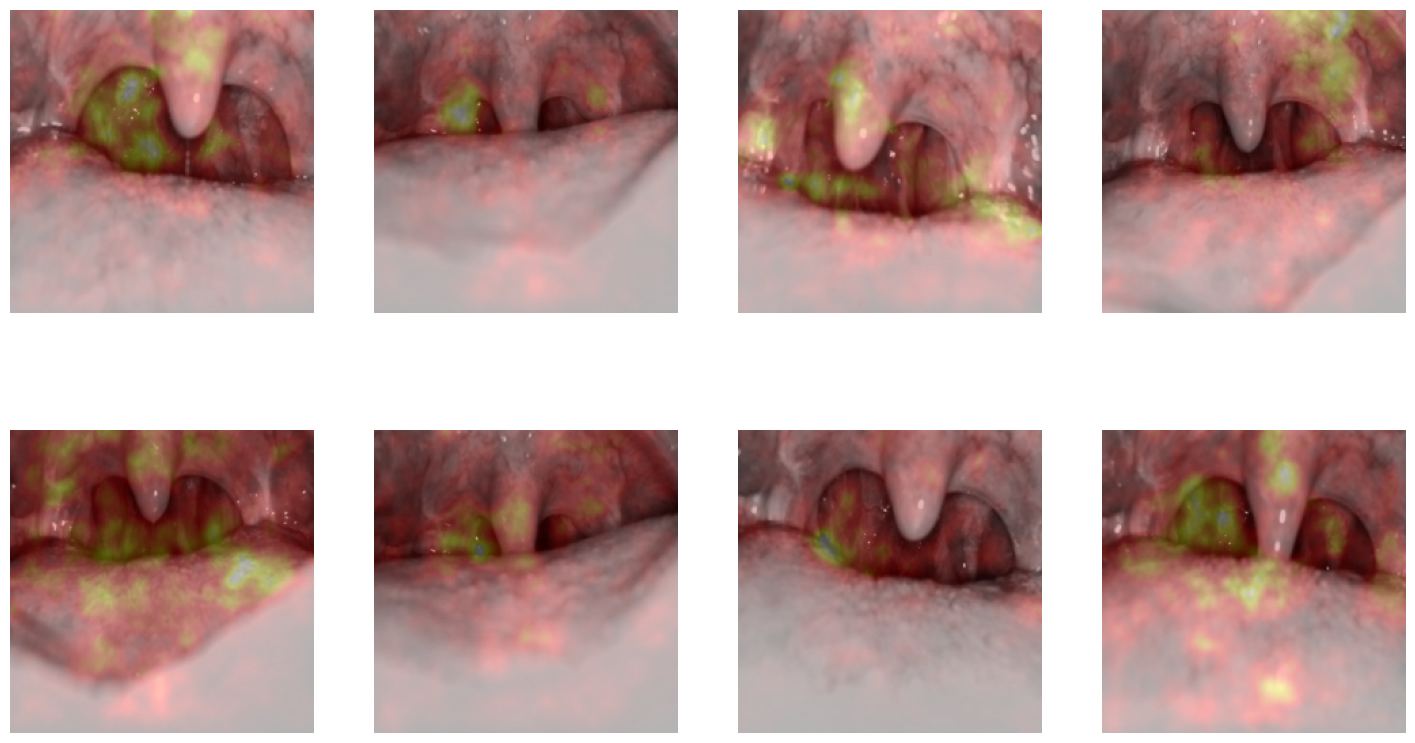

In [107]:
print('equal')
plot_saliency_maps(model, data_loader, 1)

open


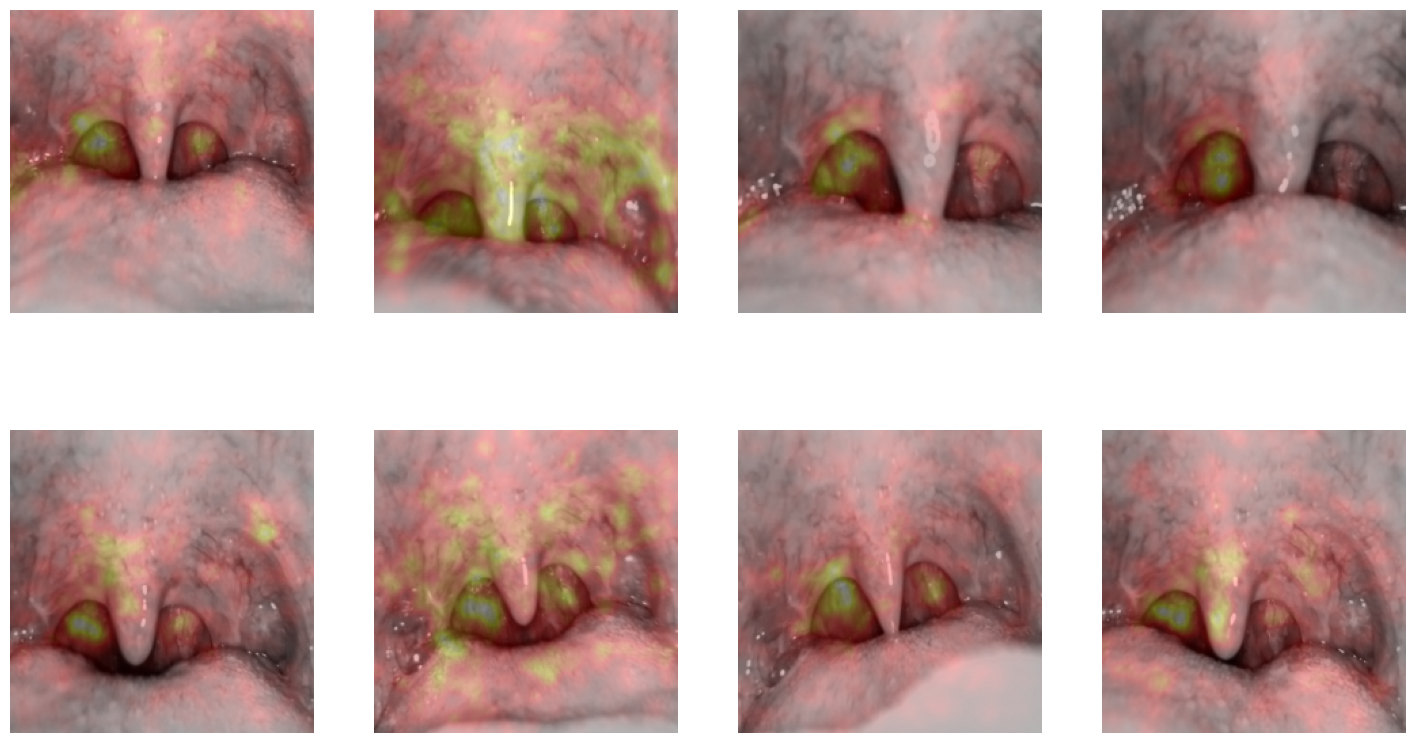

In [108]:
print('open')
plot_saliency_maps(model, data_loader, 2)